In [ ]:
l = ['0','1','2','3','4']

In [ ]:
l[0]

In [ ]:
l[-2]

**Topics to cover:**
- graph 'replaying old nodes' if they have been run? in docs and in the time-travel notebook. Not sure what it means.
- 

In [1]:
def shst(config, verbose=False):
    #config = {"configurable": {"thread_id": "1"}}
    sh = list(graph.get_state_history(config))
    lsh = len(sh)
    for i, s in enumerate(sh):
        #print(s)
        print(f'{-(lsh-i)}:{i}:{s.metadata.get("step")}', s.config["configurable"]["checkpoint_id"][-4:],
              s.next, s.values)
        if verbose:
            for i, t in enumerate(s.tasks or ()):
                print("        ",f"task[{i}] name={getattr(t, 'name', None)} result={getattr(t, 'result', None)}")
        #print(s.config["configurable"]["checkpoint_id"])

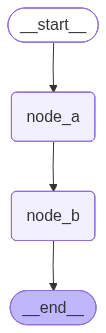

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


{'foo': 'b', 'bar': ['a', 'b']}

In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from IPython.display import Image, display

class State(TypedDict):
    foo: str = "goo"
    bar: Annotated[list[str], add]

def node_a(state: State):
    print(f"Node a receiving state {state}")
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    print(f"Node b receiving state {state}")
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph().draw_mermaid_png()))
config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": "begin"}, config)

In [3]:
shst(config)

-4:0:2 e17b () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 035b ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:2:0 0c46 ('node_a',) {'foo': 'begin', 'bar': []}
-1:3:-1 0209 ('__start__',) {'bar': []}


## get_state()

In [4]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37b4-6b96-8002-f1f377d8e17b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-21T22:35:09.869965+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37b2-6de6-8001-f810b58e035b'}}, tasks=(), interrupts=())

## get_state_history()

In [5]:
config = {"configurable": {"thread_id": "1"}}
sh = list(graph.get_state_history(config))

In [6]:
for s in sh:
    print( s)
    print()

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37b4-6b96-8002-f1f377d8e17b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-21T22:35:09.869965+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37b2-6de6-8001-f810b58e035b'}}, tasks=(), interrupts=())

StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37b2-6de6-8001-f810b58e035b'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-21T22:35:09.869204+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37af-67e0-8000-3664b3020c46'}}, tasks=(PregelTask(id='96432a81-07a4-ee7e-6403-9b5a531f261b', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(

In [7]:
sh[-3].tasks[0]



PregelTask(id='96432a81-07a4-ee7e-6403-9b5a531f261b', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(), state=None, result={'foo': 'b', 'bar': ['b']})

In [8]:
sh[-1]

StateSnapshot(values={'bar': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0aece3-37ab-691a-bfff-8c3481b80209'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-10-21T22:35:09.866213+00:00', parent_config=None, tasks=(PregelTask(id='d3523fae-15e4-b347-9756-b79d8d6b5db1', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'foo': 'begin'}),), interrupts=())

In [ ]:
sh[-2]  # start of node a i think

In [10]:
shst(config, verbose=True)

-4:0:2 e17b () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 035b ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:2:0 0c46 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:3:-1 0209 ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


## replay

In [85]:
config = {"configurable": {"thread_id": "1"}}
sh = list(graph.get_state_history(config))

nda_config = sh[-1].config
nda_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ae890-861d-6b5e-bfff-573174232288'}}

In [86]:
sh[-1]

StateSnapshot(values={'bar': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae890-861d-6b5e-bfff-573174232288'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-10-21T14:20:02.286872+00:00', parent_config=None, tasks=(PregelTask(id='8b0ded22-5667-d623-5d2d-badfba9522c2', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'foo': 'begin'}),), interrupts=())

In [87]:
graph.invoke(None, config=nda_config)

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


{'foo': 'b', 'bar': ['a', 'b']}

In [88]:
shst(config)

-7:0 a8e1 () {'foo': 'b', 'bar': ['a', 'b']}
-6:1 4a53 ('node_b',) {'foo': 'a', 'bar': ['a']}
     task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-5:2 b07e ('node_a',) {'foo': 'begin', 'bar': []}
     task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-4:3 a2ca () {'foo': 'b', 'bar': ['a', 'b']}
-3:4 e40d ('node_b',) {'foo': 'a', 'bar': ['a']}
     task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:5 f8aa ('node_a',) {'foo': 'begin', 'bar': []}
     task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:6 2288 ('__start__',) {'bar': []}
     task[0] name=__start__ result={'foo': 'begin'}


## Update state
There are 4 things to consider about `update_state`.

- what is returned by the function
- reducer behavior
- invoking with/without a checkpoint
- as node behavior

In [11]:
## start clean
import uuid
thread_id = uuid.uuid4().hex[-4:] # so we start fresh each time we run this

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
graph.invoke({"foo": "begin"}, config)
sh = list(graph.get_state_history(config))

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


In [13]:
shst(config, verbose=True)

-4:0:2 1ace () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 5c69 ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:2:0 1603 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:3:-1 faf0 ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


### What does update_state return? How is state updated (reducers)?
`update_state` generates a new checkpoint and returns a config whose `checkpoint_id` points to that checkpoint.
This example will also illustrate how state is updated.

#### Update state - no checkpoint id

In [167]:
config

{'configurable': {'thread_id': '875b'}}

In [168]:
new_config = graph.update_state(config, {"foo": 12, "bar": ["fly"]})
new_config

{'configurable': {'thread_id': '875b',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ae9e7-71c2-608a-8003-f8bcc071347a'}}

In [169]:
shst(config)

-5:0:3 347a () {'foo': 12, 'bar': ['a', 'b', 'fly']}
-4:1:2 06c4 () {'foo': 'b', 'bar': ['a', 'b']}
-3:2:1 33f6 ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:3:0 a293 ('node_a',) {'foo': 'begin', 'bar': []}
-1:4:-1 b613 ('__start__',) {'bar': []}


Note there is a new checkpoint. It is the 'current' checkpoint.

In [170]:
sh = list(graph.get_state_history(config))
sh[-5]

StateSnapshot(values={'foo': 12, 'bar': ['a', 'b', 'fly']}, next=(), config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e7-71c2-608a-8003-f8bcc071347a'}}, metadata={'source': 'update', 'step': 3, 'parents': {}}, created_at='2025-10-21T16:53:27.488298+00:00', parent_config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e7-51b1-6a5c-8002-fdd1197706c4'}}, tasks=(), interrupts=())

Other things to note: 
- `next` is not set. If you invoke from here, the graph does not run. ***??? Double check ????***
- `step` is 3, it is added as the next step.
- `parents`: is empty, though `parent_config` is the previous current node as indicated by the `checkpoint_id`

##### Over Ride Reducer?
??? can you can override the reducer in for things other than message - todo

#### Update State - with a checkpoint id
First, let's get a checkpoint ID.

In [171]:
shst(config)

-5:0:3 347a () {'foo': 12, 'bar': ['a', 'b', 'fly']}
-4:1:2 06c4 () {'foo': 'b', 'bar': ['a', 'b']}
-3:2:1 33f6 ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:3:0 a293 ('node_a',) {'foo': 'begin', 'bar': []}
-1:4:-1 b613 ('__start__',) {'bar': []}


Let's update state -2. Note, its `next` field is `node_a`.

In [172]:
sh = list(graph.get_state_history(config))
sh[-2]

StateSnapshot(values={'foo': 'begin', 'bar': []}, next=('node_a',), config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e7-51a7-6688-8000-30b5972aa293'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-21T16:53:24.121953+00:00', parent_config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e7-51a1-6b34-bfff-22aa6fccb613'}}, tasks=(PregelTask(id='245fbc47-587d-b6ac-4039-5b646dbbe890', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result={'foo': 'a', 'bar': ['a']}),), interrupts=())

In [173]:
u_config = sh[-2].config
u_config

{'configurable': {'thread_id': '875b',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ae9e7-51a7-6688-8000-30b5972aa293'}}

Ok, now we have a `update config` with a checkpoint ID.

In [174]:
new_config = graph.update_state(u_config, {"foo": 42, "bar": ["food"]})
new_config

{'configurable': {'thread_id': '875b',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ae9e8-2dba-6044-8001-a8f10b25b054'}}

In [175]:
shst(config)

-6:0:1 b054 ('node_b',) {'foo': 42, 'bar': ['a', 'food']}
-5:1:3 347a () {'foo': 12, 'bar': ['a', 'b', 'fly']}
-4:2:2 06c4 () {'foo': 'b', 'bar': ['a', 'b']}
-3:3:1 33f6 ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:4:0 a293 ('node_a',) {'foo': 'begin', 'bar': []}
-1:5:-1 b613 ('__start__',) {'bar': []}


In [177]:
sh = list(graph.get_state_history(config))
sh[-6]

StateSnapshot(values={'foo': 42, 'bar': ['a', 'food']}, next=('node_b',), config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e8-2dba-6044-8001-a8f10b25b054'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-10-21T16:53:47.198249+00:00', parent_config={'configurable': {'thread_id': '875b', 'checkpoint_ns': '', 'checkpoint_id': '1f0ae9e7-51a7-6688-8000-30b5972aa293'}}, tasks=(PregelTask(id='02752b6e-ad42-48bb-7bc1-513202fde1de', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Other things to note: 
- `next` is now set to `node_b`. If you invoke from here, the graph will start at `node_b`.
- `step` is now 1. Graphs have a max steps count. This will enable additional steps (also will prevent you from hitting the max if this is repeated).
- `parents`: is empty, though `parent_config` is the checkpoint the new checkpoint was based on.

### Update_state: as_node
`as_node` instructs the update to be done as if it were coming from a particular node. This is important because `next` is not static but is computed as part of the update. In our graph, an update from `__start__` will leave `next` set to `node_a` while an update with `as_node` set to `node_a` will leave `next` set to `node_b`.  Lets try this.

#### Start Clean

In [23]:
## start clean
import uuid
thread_id = uuid.uuid4().hex[-4:] # so we start fresh each time we run this

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
graph.invoke({"foo": "begin"}, config)

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


{'foo': 'b', 'bar': ['a', 'b']}

In [24]:
shst(config, verbose=True)

-4:0:2 6742 () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 0e77 ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:2:0 35f3 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:3:-1 5d92 ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


Lets update state using [-2] as our starting point.

In [29]:
sh = list(graph.get_state_history(config))
u_config = sh[-2].config
graph.get_state(u_config)

StateSnapshot(values={'foo': 'begin', 'bar': []}, next=('node_a',), config={'configurable': {'thread_id': 'e633', 'checkpoint_ns': '', 'checkpoint_id': '1f0aeced-56ef-65ec-8000-98df6ef135f3'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-21T22:39:41.580021+00:00', parent_config={'configurable': {'thread_id': 'e633', 'checkpoint_ns': '', 'checkpoint_id': '1f0aeced-56ec-6e64-bfff-aa26af7b5d92'}}, tasks=(PregelTask(id='3dbda42f-e594-1846-a64f-75d38056c2a6', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result={'foo': 'a', 'bar': ['a']}),), interrupts=())

In [26]:
for i, node in enumerate(graph.nodes):
    print(node)
    # create a new checkpoint
    new_config = graph.update_state(u_config, {"foo": 42+i, "bar": [f"as_node {node}"]}, as_node=node)
    s = graph.get_state(new_config)
    print(f'{s.metadata.get("step")}', s.config["configurable"]["checkpoint_id"][-4:],s.next, s.values)


__start__
1 904b ('node_a',) {'foo': 42, 'bar': ['a', 'as_node __start__']}
node_a
1 197b ('node_b',) {'foo': 43, 'bar': ['a', 'as_node node_a']}
node_b
1 c537 () {'foo': 44, 'bar': ['a', 'as_node node_b']}


In [27]:
shst(config,verbose=True)

-7:0:1 c537 () {'foo': 44, 'bar': ['a', 'as_node node_b']}
-6:1:1 197b ('node_b',) {'foo': 43, 'bar': ['a', 'as_node node_a']}
         task[0] name=node_b result=None
-5:2:1 904b ('node_a',) {'foo': 42, 'bar': ['a', 'as_node __start__']}
         task[0] name=node_a result=None
-4:3:2 6742 () {'foo': 'b', 'bar': ['a', 'b']}
-3:4:1 0e77 ('node_b',) {'foo': 'a', 'bar': ['a']}
         task[0] name=node_b result={'foo': 'b', 'bar': ['b']}
-2:5:0 35f3 ('node_a',) {'foo': 'begin', 'bar': []}
         task[0] name=node_a result={'foo': 'a', 'bar': ['a']}
-1:6:-1 5d92 ('__start__',) {'bar': []}
         task[0] name=__start__ result={'foo': 'begin'}


### Invoking
- ```graph.invoke(None,config)``` - The `None` indicates the graph should _resume_ operation vs start.
    - if config contains a thread but _no checkpoint_, operation resumes from the last checkpoint or "current state"
    - If config contains a thread and _a checkpoint_, then operation will resume from that checkpoint.
    - 
What does 'from that checkpoint' mean? A checkpoint contains state at the end of a super step. So, this is like normal operation. The next field indicates the next node, and the state is supplied as the initial state to that node.

??? are results copied?, what about map reduce - what does 'next' look like there. 

{'__start__': <langgraph.pregel._read.PregelNode at 0x10b382b10>,
 'node_a': <langgraph.pregel._read.PregelNode at 0x10b381c10>,
 'node_b': <langgraph.pregel._read.PregelNode at 0x10b381f10>}

We can invoke this, but, because `next` is empty, it does not invoke the graph again.

In [137]:
graph.invoke(None, config=new_config)

{'foo': 12, 'bar': ['a', 'b', 'fly']}

In [138]:
shst(config)

-5:0:3 ead8 () {'foo': 12, 'bar': ['a', 'b', 'fly']}
-4:1:2 d8a4 () {'foo': 'b', 'bar': ['a', 'b']}
-3:2:1 2dff ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:3:0 8d33 ('node_a',) {'foo': 'begin', 'bar': []}
-1:4:-1 91d2 ('__start__',) {'bar': []}


#### Start Clean

In [179]:
## start clean
import uuid
thread_id = uuid.uuid4().hex[-4:] # so we start fresh each time we run this

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
graph.invoke({"foo": "begin"}, config)
sh = list(graph.get_state_history(config))

Node a receiving state {'foo': 'begin', 'bar': []}
Node b receiving state {'foo': 'a', 'bar': ['a']}


In [180]:
shst(config)

-4:0:2 551d () {'foo': 'b', 'bar': ['a', 'b']}
-3:1:1 03be ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:2:0 dd6b ('node_a',) {'foo': 'begin', 'bar': []}
-1:3:-1 3507 ('__start__',) {'bar': []}


Lets update state before entering `node_a`. This is a index -2.
Recall we must get the config and checkpoint like this:

In [181]:
sh = list(graph.get_state_history(config))
u_config = sh[-2].config

In [182]:
u_config

{'configurable': {'thread_id': 'be69',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0aea36-5705-6810-8000-37f8d6dcdd6b'}}

We can take a look at that state, double-check the next is `node_a`.

In [184]:
graph.get_state(u_config)

StateSnapshot(values={'foo': 'begin', 'bar': []}, next=('node_a',), config={'configurable': {'thread_id': 'be69', 'checkpoint_ns': '', 'checkpoint_id': '1f0aea36-5705-6810-8000-37f8d6dcdd6b'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-21T17:28:45.324894+00:00', parent_config={'configurable': {'thread_id': 'be69', 'checkpoint_ns': '', 'checkpoint_id': '1f0aea36-56fb-69fa-bfff-93688d803507'}}, tasks=(PregelTask(id='f2e29fe0-2cfc-1d39-6947-85615c14b49c', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result={'foo': 'a', 'bar': ['a']}),), interrupts=())

In [185]:
new_config = graph.update_state(u_config, {"foo": 67, "bar": ["oque"]})

Let's check our new checkpoint:

In [186]:
graph.get_state(new_config)

StateSnapshot(values={'foo': 67, 'bar': ['a', 'oque']}, next=('node_b',), config={'configurable': {'thread_id': 'be69', 'checkpoint_ns': '', 'checkpoint_id': '1f0aeb35-6708-64c4-8001-05a5a211c3f0'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-10-21T19:22:52.107883+00:00', parent_config={'configurable': {'thread_id': 'be69', 'checkpoint_ns': '', 'checkpoint_id': '1f0aea36-5705-6810-8000-37f8d6dcdd6b'}}, tasks=(PregelTask(id='989b4c96-0889-27da-e477-c46d4e20f909', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [188]:
shst(config)  # state history of thread

-5:0:1 c3f0 ('node_b',) {'foo': 67, 'bar': ['a', 'oque']}
-4:1:2 551d () {'foo': 'b', 'bar': ['a', 'b']}
-3:2:1 03be ('node_b',) {'foo': 'a', 'bar': ['a']}
-2:3:0 dd6b ('node_a',) {'foo': 'begin', 'bar': []}
-1:4:-1 3507 ('__start__',) {'bar': []}
